# Agentic Workflow

In [52]:
%pip install -Uqqq pip --progress-bar off
%pip install -Uqqq langchain --progress-bar off
%pip install -Uqqq langchain-openai --progress-bar off
%pip install -Uqqq langchain-google-genai --progress-bar off
%pip install -Uqqq langchain-ollama --progress-bar off
%pip install -Uqqq langchain-community --progress-bar off
%pip install -Uqqq pypdf --progress-bar off
%pip install -Uqqq fastembed --progress-bar off
%pip install -Uqqq langgraph --progress-bar off
%pip install -Uqqq langchain-core --progress-bar offs


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

option --progress-bar: invalid choice: 'offs' (choose from 'auto', 'on', 'off', 'raw')


In [53]:
# Used to easily create classes for storing data.
from dataclasses import dataclass, field
# Provides type hints for better code readability and maintainability.
from typing import Annotated, List, TypedDict
# Used to display images and other rich output in IPython/Colab.
from IPython.display import Image, display
# Initializes a chat model for language model interactions.
from langchain.chat_models import init_chat_model
# Provides fast and efficient embeddings for text.
from langchain_community.embeddings import HuggingFaceEmbeddings
# Represents a document object, often used in retrieval systems.
from langchain_core.documents import Document
# Represents different types of messages in a conversation.
from langchain_core.messages import AnyMessage, HumanMessage
# Creates templates for generating chat prompts.
from langchain_core.prompts import ChatPromptTemplate
# Decorator to define a function as a tool for language models.
from langchain_core.tools import tool
# An in-memory vector store for storing and searching vector embeddings.
from langchain_core.vectorstores import InMemoryVectorStore
# Components for building state graphs in LangGraph.
from langgraph.graph import END, StateGraph
# Function to add messages to the state in LangGraph.
from langgraph.graph.message import add_messages

In [54]:
from langchain_community.llms import HuggingFacePipeline
from transformers import pipeline

pipe = pipeline("text2text-generation", model="google/flan-t5-large", temperature=0.7, max_length=512)
llm = HuggingFacePipeline(pipeline=pipe)


Device set to use cpu


# Workflow

In [55]:
@dataclass # defines structure of a our LangChain states
class TicketTriageState:
  ticket_text: str
  classification: str= "" #
  retrieved_docs: List[Document] = field(default_factory=lambda: []) # subject to change
  draft_response: str = ""
  evaluation_feedback: str = ""
  revision_count: int = 0 # sets revision_count to 0 to start

# Nodes
In LangGraph, a node is a function that represents a single unit of computation or a specific step in a workflow.

## Adding a classification to the prompt that the model was given

In [72]:
CLASSIFY_PROMPT = """
Classify this support ticket into one of the following categories:
'Technical Issue', 'Billing Inquiry', 'General Question'.

<ticket>
{ticket_text}
</ticket>
""".strip()

def classify_ticket(state: TicketTriageState) -> dict:
  classification = llm.invoke(CLASSIFY_PROMPT.format(ticket_text=state.ticket_text))
  # returns a dictionary, where "classification" is the key, and the value is what the LLM
  # generated from the line above. It took the ticket_text from the dataclass we defined earlier,
  # and used the state's ticket_text to give the ticket a classification
  return {"classification": classification}

## Contacting the knowledge base

In [57]:
from langchain_community.embeddings import FastEmbedEmbeddings

knowledge_base = [
    "For login issues, tell the user to try resetting their password via the 'Forgot Password' link.",
    "Billing inquiries should be escalated to the billing department by creating a ticket in Salesforce.",
    "The app is known to crash on startup if the user's cache is corrupted. The standard fix is to clear the application cache.",
]

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

vector_store = InMemoryVectorStore.from_texts(knowledge_base, embeddings)
retriever = vector_store.as_retriever()


def retrieve_knowledge(state: TicketTriageState) -> dict:
    retrieved_docs = retriever.invoke(state.ticket_text)
    return {"retrieved_docs": retrieved_docs}

## Drafting the response

In [58]:
DRAFT_PROMPT = """
Based on this context:
<context>
{context}
</context>

Draft a response for this ticket:
<ticket>
{ticket}
</ticket>
""".strip()

def draft_response(state: TicketTriageState) -> dict:
  context = "\n".join([doc.page_content for doc in state.retrieved_docs])
  prompt = DRAFT_PROMPT.format(context=context, ticket=state.ticket_text)
  draft = llm.invoke(prompt)
  return {"draft_response": draft}


## Response evaluation

In [59]:
EVALUATE_PROMPT = """
Does this draft
<draft>
{draft_response}
</draft>

fully address the ticket

<ticket>
{ticket_text}
</ticket>

If not, provide feedback.
Respond with 'PASS' or 'FAIL: [feedback]'."
""".strip()

def evaluate_draft(state: TicketTriageState) -> dict:
  evaluation_prompt = EVALUATE_PROMPT.format(
    draft_response=state.draft_response,
    ticket_text=state.ticket_text,
  )
  evaluation_result = llm.invoke(evaluation_prompt)
  revision_count = state.revision_count + 1
  return {"evaluation_feedback": evaluation_result, "revision_count": revision_count}

## Revising the response draft

In [60]:
REVISE_PROMPT = """
Revise this draft:
<draft>
{draft_response}
</draft>

based on the following feedback:

<feedback>
{evaluation_feedback}
</feedback>
""".strip()

def revise_response(state: TicketTriageState) -> dict:
  revise_prompt = REVISE_PROMPT.format(
    draft_response=state.draft_response,
    evaluation_feedback=state.evaluation_feedback,
  )
  return {"draft_response": llm.invoke(revise_prompt)}

## If "FAIL," revise

In [61]:
def should_revise(state: TicketTriageState) -> str:
    feedback = state.evaluation_feedback
    revision_count = state.revision_count

    if "FAIL" in feedback and revision_count < 3:
        return "revise"
    else:
        return "end"

## Generating our graph

In [62]:
graph = StateGraph(TicketTriageState)

# all of the nodes we just defined
graph.add_node("classify", classify_ticket)
graph.add_node("retrieve", retrieve_knowledge)
graph.add_node("draft", draft_response)
graph.add_node("evaluate", evaluate_draft)
graph.add_node("revise", revise_response)


# we connect all the nodes with edges
graph.add_edge("classify", "retrieve")
graph.add_edge("retrieve", "draft")
graph.add_edge("draft", "evaluate")

graph.add_edge("revise", "evaluate")

graph.add_conditional_edges( # if we need to revise the draft, we will go back to revise node
                            # otherwise, we end execution
    "evaluate",
    should_revise,
    {
        "revise": "revise",
        "end": END,
    },
)

graph.set_entry_point("classify") # all support tickets start with classify node
app = graph.compile() # puts our graph together

### Displaying the graph

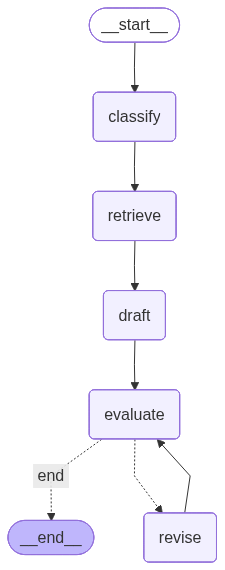

In [63]:
display(Image(app.get_graph().draw_mermaid_png())) # our compiled graph

## Running the workflow

In [64]:
# Test the system
initial_state = {
    "ticket_text": "My login is broken, please help!",
    "retrieved_docs": [],
    "classification": "", # Changed from category to classification
    "draft_response": "" # Changed from response to draft_response
}

final_state = app.invoke(initial_state)

# prints our final state stuff
print("=== TICKET TRIAGE RESULTS ===")
print(f"Original Ticket: {final_state['ticket_text']}")
print(f"Classification: {final_state['classification']}")
# print(f"Priority: {final_state['priority']}") # maybe add Priority later
print(f"\nResponse:\n{final_state['draft_response']}")

=== TICKET TRIAGE RESULTS ===
Original Ticket: My login is broken, please help!
Classification: Technical Issue

Response:
For login issues, tell the user to try resetting their password via the 'Forgot Password' link. The app is known to crash on startup if the user's cache is corrupted. The standard fix is to clear the application cache. Billing inquiries should be escalated to the billing department by creating a ticket in Salesforce.


### Print the final classification

In [65]:
print(final_state["classification"])

Technical Issue


### Print the revision count

In [66]:
print(final_state["revision_count"])

1


Print the draft of the response

In [67]:
print(final_state["draft_response"])

For login issues, tell the user to try resetting their password via the 'Forgot Password' link. The app is known to crash on startup if the user's cache is corrupted. The standard fix is to clear the application cache. Billing inquiries should be escalated to the billing department by creating a ticket in Salesforce.
